This file will be to make figure 1 or the triangle plot from Sen 2015. We need to do the following steps to produce this plot:
1. Select systems of interest - in our case these are binary white dwarfs
2. Select the masses of these systems were M1>M2
3. Make a skeleton plot of the triangle plot but setting mass and stellar type bounds
4. Make a 2D histogram or density plot the includes redshift information (at a sepcific redshift or over all redshifts)

### 1. Selecting Systems of Interest

In [2]:
# let's import things
import h5py as h5 
import pandas as pd
from astropy.table import Table
from astropy import units as u
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text.latex', preamble=r'\usepackage{textgreek}')
plt.rc('font', family='serif')
import sys
import os

# Add the subdir to sys.path
sys.path.append('/home/jovyan/home/research_work/useful_py_scripts/')

# Now you can import the module
import useful_fncs 

In [3]:
# now let's make a bool or use numpy.isin to select for BWDs

### 2. Select the Masses of these Systems

### 3. Make a Skeleton Plot

In [74]:
# to test our plot let's make a random array of values for the masses
from numpy import random

Mass1 = random.rand(100)
Mass2 = random.rand(100)

Text(0, 0.5, '$M_{2}/M_{\\odot}$')

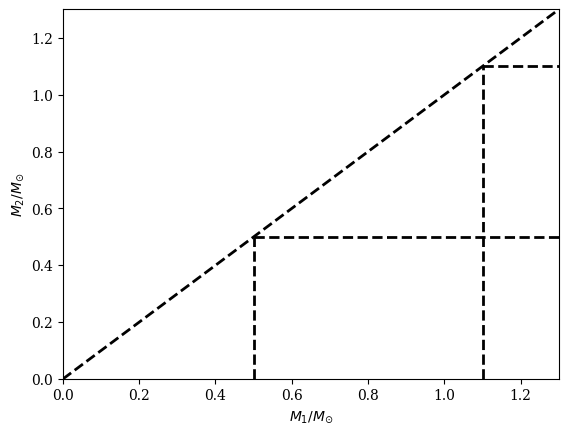

In [77]:
# we need to make sure that we are only selecting for M1 that is larger than M2
M1 = []
M2 = []
for i in range(len(Mass1)):
    if Mass1[i]>Mass2[i]:
        M1.append(Mass1[i])
    if Mass2[i]<Mass1[i]:
        M2.append(Mass2[i])


#let's plot the masses
# plt.plot(M1,M2)

# let's add the restrictive lines to the plot
# there should be no plots in the upper left triangle because M1>M2

plt.axline((0,0), (1.3,1.3), color="black", ls='--', lw = 2, transform=plt.gca().transAxes)

xlim = 1.3
ylim = 1.3

# let's add the mass restrictions for each case of BWD
#Helium WD cutoff
plt.vlines(x=[0.5], ymin=0, ymax=0.5, colors='black', ls='--', lw=2)
plt.axhline(y=0.5, color='black', xmin = 0.5/xlim, xmax = 1.3/xlim, ls='--', lw=2) # for axhline, the xmin and mxmax are scale factors of the axis not positions
#Carbon oxygen WD cutoff
plt.vlines(x=[1.1], ymin=0, ymax=1.1, colors='black', ls='--', lw=2)
plt.axhline(y=1.1, color='black', xmin = 1.1/xlim, xmax = 1.3/xlim, ls='--', lw=2)


# setting the limits of the plot
plt.xlim(0,xlim)
plt.ylim(0,ylim)

# axes labels
plt.xlabel("$M_{1}/M_{\odot}$")
plt.ylabel("$M_{2}/M_{\odot}$")

### 4. Make a Density plot

/tmp/ipykernel_8425/549158237.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


Text(0, 0.5, '$M_{2}/M_{\\odot}$')

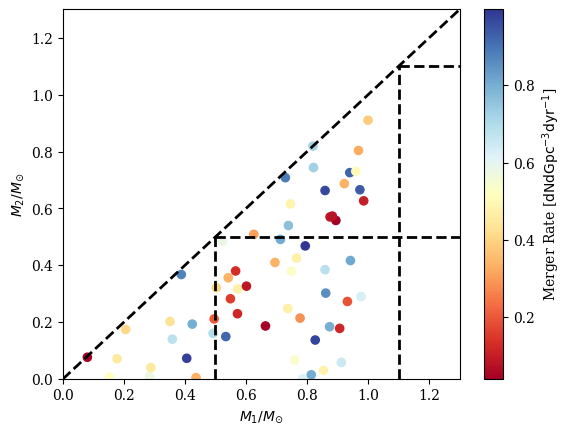

In [83]:
# for the 2D histogram or density plot, we must consider the rates for each system plotted above

# let's first define an array of rates 
rates_systems = np.random.rand(len(M1))#make some numbers up for now until we actually comput the rates 

# let's define what we want to plot and the rates associated with each system 
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(M1, M2, c=rates_systems, s=35, cmap=cm)

plt.colorbar(sc, label="Merger Rate [$\mathrm{dNdGpc^{-3}dyr^{-1}}$]")

# let's add the restrictive lines to the plot
# there should be no plots in the upper left triangle because M1>M2

plt.axline((0,0), (1.3,1.3), color="black", ls='--', lw = 2, transform=plt.gca().transAxes)

xlim = 1.3
ylim = 1.3

# let's add the mass restrictions for each case of BWD
#Helium WD cutoff
plt.vlines(x=[0.5], ymin=0, ymax=0.5, colors='black', ls='--', lw=2)
plt.axhline(y=0.5, color='black', xmin = 0.5/xlim, xmax = 1.3/xlim, ls='--', lw=2) # for axhline, the xmin and mxmax are scale factors of the axis not positions
#Carbon oxygen WD cutoff
plt.vlines(x=[1.1], ymin=0, ymax=1.1, colors='black', ls='--', lw=2)
plt.axhline(y=1.1, color='black', xmin = 1.1/xlim, xmax = 1.3/xlim, ls='--', lw=2)


# setting the limits of the plot
plt.xlim(0,xlim)
plt.ylim(0,ylim)

# axes labels
plt.xlabel("$M_{1}/M_{\odot}$")
plt.ylabel("$M_{2}/M_{\odot}$")